# Topical Analysis

This notebook extends the analysis done in Filippou et al. (2024) to a topical level.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


chunk_predictions = pd.read_csv("chunk_predictions.csv")
chunk_predictions = chunk_predictions.drop("Text", axis=1)
results_df = chunk_predictions

In [9]:
# Want to aggregate by month instead of quarter

# Step 1: Extract Year and Report Number
results_df["Year"] = results_df["Filename"].str.extract(r"(\d{4})").astype(int)
results_df["Report_Number"] = results_df["Filename"].str.extract(r"\((\d+)\)").astype(int)

# Step 2: Map Report Numbers to Months
    # Got months from Fed website and put them in a spreadsheet
    # See C:\Users\MCOB PHD 14\Desktop\bbFinal\Notebooks\BB_publication_months.xlsx
def get_month(year, report_number):
    # Define mappings for report numbers to months
    if 1970 <= year <= 1978:
        month_mapping = {1: "12", 2: "11", 3: "10", 4: "09", 5: "08", 6: "07", 7: "06", 8: "05", 9: "04", 
                         10: "03", 11: "02", 12: "01"}
    elif year == 1979:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "08", 5: "07", 6: "05", 7: "04", 8: "03", 9: "01"}
    elif year == 1980:
        month_mapping = {1: "12", 2: "11", 3: "10", 4: "09", 5: "08", 6: "07", 7: "05", 8: "04", 9: "03", 10: "01"}
    elif year in {1981, 2017, 2023}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "07", 5: "05", 6: "04", 7: "03", 8: "01"}
    elif year == 2012:
        month_mapping = {1: "11", 2: "10", 3: "08", 4: "07", 5: "06", 6: "04", 7: "02", 8: "01"}
    elif year in {2018, 2020, 2024}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "07", 5: "05", 6: "04", 7: "03", 8: "01"}
    elif year in {2002, 2003, 2005, 2006, 2007, 2011, 2016, 2019, 2022}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "07", 5: "06", 6: "04", 7: "03", 8: "01"}
    elif year in {2004, 2008, 2009, 2010, 2013, 2014, 2015, 2021}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "07", 5: "06", 6: "04", 7: "03", 8: "01"}
    elif year in {1988, 2001}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    elif year == 1983:
        month_mapping = {1: "12", 2: "11", 3: "09", 4: "08", 5: "07", 6: "05", 7: "03", 8: "02"}
    elif year in {1984, 1985, 1986, 1987, 1990, 1991, 1996, 1997}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    else:
        month_mapping = {1: "12", 2: "11", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    return month_mapping.get(report_number, "Unknown")

results_df["Month"] = results_df.apply(lambda row: get_month(row["Year"], row["Report_Number"]), axis=1)

# Step 3: Convert Year and Month to Date-Time Format
results_df["DATE"] = results_df.apply(lambda row: f"{row['Year']}-{row['Month']}-01", axis=1)
results_df["DATE"] = pd.to_datetime(results_df["DATE"], errors="coerce")

# Step 4: Aggregate Data by Month
topic_columns_original = ["Employment", "Prices", "Consumption", "Manufacturing", "Construction",
                 "Lending", "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]

aggregated_df = results_df.groupby("DATE")[topic_columns].sum().reset_index()

# Export to csv
#aggregated_df.to_csv("aggregated_predictions_monthly.csv", index=False)

df = aggregated_df
df['DATE'] = pd.to_datetime(df['DATE'])

# Create dummy variable for dates of recessions
    # Dates defined by Business Cycle Dating Committee of the NBER
df["Recession"] = 0
df.loc[(df["DATE"] >= "1969-12-01") & (df["DATE"] <= "1970-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1973-11-01") & (df["DATE"] <= "1975-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1980-01-01") & (df["DATE"] <= "1980-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1981-07-01") & (df["DATE"] <= "1982-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1990-07-01") & (df["DATE"] <= "1991-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2001-03-01") & (df["DATE"] <= "2001-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2007-12-01") & (df["DATE"] <= "2009-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2020-02-01") & (df["DATE"] <= "2020-04-01"), "Recession"] = 1


# Check for multicollinearity

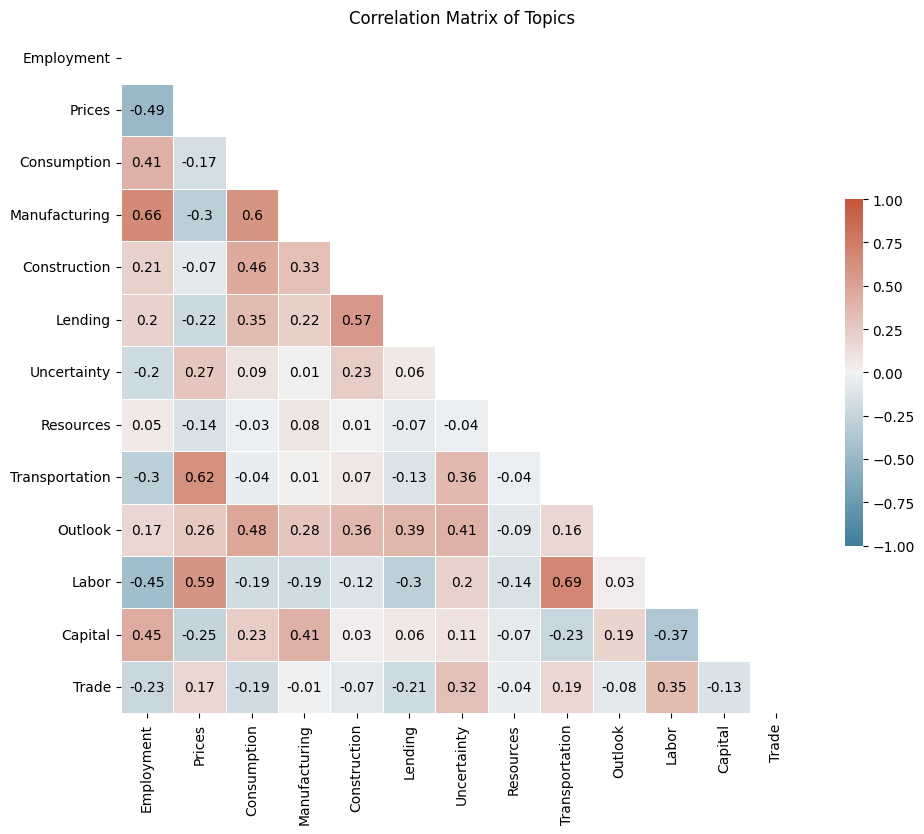

In [17]:
# Correlation matrix

corr = df[topic_columns_original].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show numbers in heatmap but only on lower triangle
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i > j:
            ax.text(j + 0.5, i + 0.5, round(corr.iloc[i, j], 2), ha='center', va='center', color='black')
plt.title("Correlation Matrix of Topics")
plt.show()

# None above 0.7 but some are close
    # Need VIF even if not high correlations

In [32]:
# Check VIFs for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = (df[topic_columns_original])
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values("VIF", ascending=False)
print(vif)

# Lending and consumption both have VIFs close to 10, so we will drop both

          Variable        VIF
5          Lending  10.210295
2      Consumption   9.288462
4     Construction   5.923758
0       Employment   5.890261
3    Manufacturing   5.474942
1           Prices   5.436210
10           Labor   4.963364
8   Transportation   3.900091
7        Resources   3.825221
6      Uncertainty   3.446500
11         Capital   3.300496
9          Outlook   2.980609
12           Trade   1.951134


In [33]:
topic_columns = ["Employment", "Prices", "Manufacturing", "Construction",
                 "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]

X = (df[topic_columns])
vif_2 = pd.DataFrame()
vif_2["Variable"] = X.columns
vif_2["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_2 = vif_2.sort_values("VIF", ascending=False)
print(vif_2)

# All VIFs are well below 10
    # Some are near 5, but that is still acceptable
    # Would like to include them to interpret their

          Variable       VIF
0       Employment  5.558650
1           Prices  5.238183
8            Labor  4.707350
2    Manufacturing  4.597238
3     Construction  3.779543
6   Transportation  3.707350
4      Uncertainty  3.434930
5        Resources  3.352829
9          Capital  3.213317
7          Outlook  2.835685
10           Trade  1.908978


In [50]:
# Merge the two DataFrames on the "Variable" column
vif_combined = pd.merge(vif, vif_2, on="Variable", how="outer")



# Sort by Variable name for consistency
vif_combined.sort_values(by="VIF_x", inplace=True, ascending=False)
vif_combined.reset_index(drop=True, inplace=True)

# Rename columns for better readability
vif_combined.columns = ["Variable", "Original", "After Removal"]

# Round to 1 decimal point for better readability for both columns using round function from Pandas
vif_combined["Original"] = vif_combined["Original"].round(1)
vif_combined["After Removal"] = vif_combined["After Removal"].round(1)

# Replace NaN with "Removed" for better readability
vif_combined.fillna("--", inplace=True)
# Optionally save the table as a CSV for further use
#vif_combined.to_csv("vif_combined_report.csv", index=False)

# Display the final table
vif_combined



C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_3968\1720123474.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  vif_combined.fillna("--", inplace=True)


,Variable,Original,After Removal
0,Lending,10.2,--
1,Consumption,9.3,--
2,Construction,5.9,3.8
3,Employment,5.9,5.6
4,Manufacturing,5.5,4.6
5,Prices,5.4,5.2
6,Labor,5.0,4.7
7,Transportation,3.9,3.7
8,Resources,3.8,3.4
9,Uncertainty,3.4,3.4


# Using topical counts to forecast recessions

In [97]:
# This is the same approach as Table 1, column 4 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment
# Probit model where 1 = economy in a recession, as defined by NBER

# Define X as including all the topic columns
X = df[topic_columns]
X = sm.add_constant(X)
y = df['Recession']

# Fit a logit model
model_now = sm.Probit(y, X).fit()

# Print the summary
model_now.summary()

Optimization terminated successfully.
         Current function value: 0.207249
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              Recession   No. Observations:                  470
Model:                         Probit   Df Residuals:                      458
Method:                           MLE   Df Model:                           11
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                  0.4892
Time:                        16:51:49   Log-Likelihood:                -97.407
converged:                       True   LL-Null:                       -190.70
Covariance Type:            nonrobust   LLR p-value:                 4.487e-34
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.0802      0.592     -8.580      0.000      -6.241      -3.920
Employment         0.1989      0.037      5.383      0.000       0.126       0.271
Prices             0.1263      0.031      4.011      0.000       0.065       0.188
Manufacturing      0.0464      0.030      1.531      0.126      -0.013       0.106
Construction       0.0484      0.019      2.584      0.010       0.012       0.085
Uncertainty       -0.1651      0.050     -3.316      0.001      -0.263      -0.068
Resources          0.0980      0.028      3.516      0.000       0.043       0.153
Transportation    -0.1119      0.052     -2.146      0.032      -0.214      -0.010
Outlook            0.1809      0.052      3.481      0.000       0.079       0.283
Labor              0.0070      0.026      0.265      0.791      -0.045       0.059
Capital            0.1184      0.046      2.567      0.010       0.028       0.209
Trade              0.0998      0.033      3.038      0.002       0.035       0.164
==================================================================================
"""

In [64]:
# Marginal effects from probit model
marginal_effects_now = model_now.get_margeff()
marginal_effects_now.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:              Recession
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Employment         0.0227      0.004      5.850      0.000       0.015       0.030
Prices             0.0144      0.003      4.181      0.000       0.008       0.021
Manufacturing      0.0053      0.003      1.544      0.123      -0.001       0.012
Construction       0.0055      0.002      2.587      0.010       0.001       0.010
Uncertainty       -0.0188      0.006     -3.415      0.001      -0.030      -0.008
Resources          0.0112      0.003      3.584      0.000       0.005       0.017
Transportation    -0.0128      0.006     -2.146      0.032      -0.024      -0.001
Outlook            0.0206      0.006      3.614      0.000       0.009       0.032
Labor              0.0008      0.003      0.264      0.791      -0.005       0.007
Capital            0.0135      0.005      2.605      0.009       0.003       0.024
Trade              0.0114      0.004      3.110      0.002       0.004       0.019
==================================================================================
"""

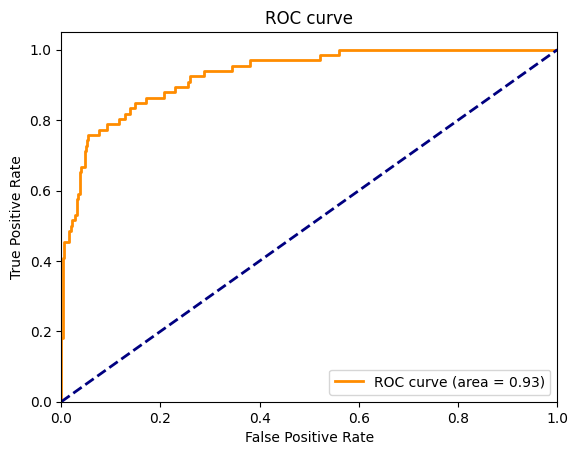

0.929005400540054

In [65]:
# ROC curve for probit model
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model_now.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [ ]:
# Import brief score loss function
from sklearn.metrics import brier_score_loss

# Predicted probabilities
predicted_probabilities = model_now.predict(X)

# Actual outcomes
actual_outcomes = y

# Calculate the Brier score
brier_score = brier_score_loss(actual_outcomes, predicted_probabilities)

print(f"Brier Score: {brier_score:.4f}")


Brier Score: 0.0610


In [ ]:
# Calculate precision and recall
from sklearn.metrics import precision_score, recall_score

# Predicted classes
predicted_classes = (predicted_probabilities > 0.5).astype(int)

# Calculate precision
precision = precision_score(actual_outcomes, predicted_classes)

# Calculate recall
recall = recall_score(actual_outcomes, predicted_classes)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.7556
Recall: 0.5152


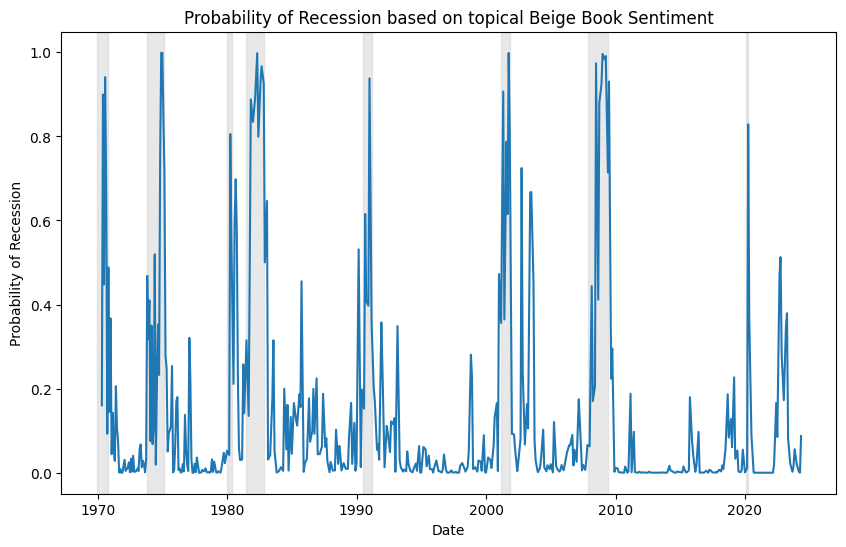

In [6]:
# This recreates Figure 2 from Filippou et al. (2024)
    # Clearly, sentiment from Beige Books is useful for predicting recessions
    # But also want to do this with the leads to see probability of a recession 3 mohths and 6 months out

# Calculate probabilities from the logit model above
df['Recession_probability'] = model_now.predict(X)

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['Recession_probability'])
plt.xlabel('Date')
plt.ylabel('Probability of Recession')
plt.title('Probability of Recession based on topical Beige Book Sentiment')

# Add recession bars
plt.axvspan("1969-12-01", "1970-11-01", color='lightgray', alpha=0.5)
plt.axvspan("1973-11-01", "1975-03-01", color='lightgray', alpha=0.5)
plt.axvspan("1980-01-01", "1980-06-01", color='lightgray', alpha=0.5)
plt.axvspan("1981-07-01", "1982-11-01", color='lightgray', alpha=0.5)
plt.axvspan("1990-07-01", "1991-03-01", color='lightgray', alpha=0.5)
plt.axvspan("2001-03-01", "2001-11-01", color='lightgray', alpha=0.5)
plt.axvspan("2007-12-01", "2009-06-01", color='lightgray', alpha=0.5)
plt.axvspan("2020-02-01", "2020-04-01", color='lightgray', alpha=0.5)

plt.show()


# Lags of topical sentiment to backcast recessions

This follows Filippou et al., 2024

In [130]:
# Create lags of dependent variable

# Create a three-month lag of the Recession dummy variable
df['Recession_lag_3'] = df['Recession'].shift(-3)

# Create a six-month lag of the Recession dummy variable
df['Recession_lag_6'] = df['Recession'].shift(-6)

In [101]:
# This is the same approach as Table 1, column 2 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lag_6"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the six-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_6']

# Fit the model with a logistic regression
model_lag_6 = sm.Probit(y, X).fit()

# Print the summary
model_lag_6.summary()

Optimization terminated successfully.
         Current function value: 0.323731
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:        Recession_lag_6   No. Observations:                  464
Model:                         Probit   Df Residuals:                      452
Method:                           MLE   Df Model:                           11
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.1593
Time:                        10:04:04   Log-Likelihood:                -150.21
converged:                       True   LL-Null:                       -178.67
Covariance Type:            nonrobust   LLR p-value:                 3.433e-08
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.0037      0.363     -5.514      0.000      -2.716      -1.292
Employment        -0.1001      0.032     -3.098      0.002      -0.164      -0.037
Prices             0.0431      0.023      1.887      0.059      -0.002       0.088
Manufacturing      0.0499      0.028      1.790      0.074      -0.005       0.105
Construction       0.0541      0.015      3.681      0.000       0.025       0.083
Uncertainty       -0.1369      0.035     -3.882      0.000      -0.206      -0.068
Resources          0.0958      0.023      4.081      0.000       0.050       0.142
Transportation    -0.0601      0.036     -1.675      0.094      -0.130       0.010
Outlook            0.1153      0.042      2.716      0.007       0.032       0.199
Labor             -0.0143      0.020     -0.708      0.479      -0.054       0.025
Capital            0.0437      0.041      1.060      0.289      -0.037       0.125
Trade              0.0455      0.024      1.930      0.054      -0.001       0.092
==================================================================================
"""

In [102]:
# Predicted probabilities
predicted_probabilities = model_lag_6.predict(X)

# Actual outcomes
actual_outcomes = y

# Calculate the Brier score
brier_score = brier_score_loss(actual_outcomes, predicted_probabilities)

print(f"Brier Score Lag 6 model: {brier_score:.4f}")


Brier Score Lag 6 model: 0.0973


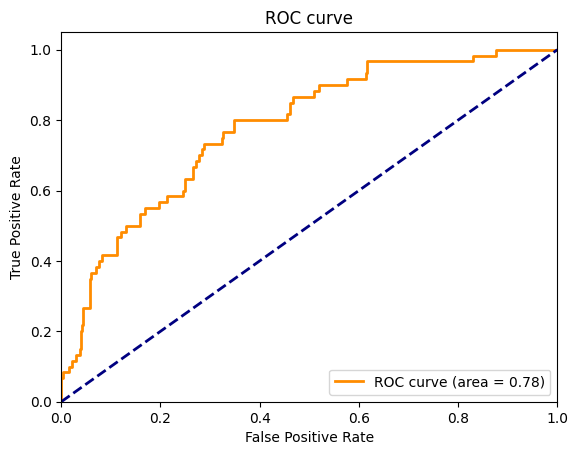

0.779950495049505

In [59]:
# ROC curve for probit model
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model_lag_6.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [66]:
# Marginal effects from probit model
marginal_effects_lag_6 = model_lag_6.get_margeff()
marginal_effects_lag_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:        Recession_lag_6
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Employment        -0.0179      0.006     -3.145      0.002      -0.029      -0.007
Prices             0.0077      0.004      1.896      0.058      -0.000       0.016
Manufacturing      0.0089      0.005      1.801      0.072      -0.001       0.019
Construction       0.0096      0.003      3.764      0.000       0.005       0.015
Uncertainty       -0.0244      0.006     -3.953      0.000      -0.037      -0.012
Resources          0.0171      0.004      4.188      0.000       0.009       0.025
Transportation    -0.0107      0.006     -1.682      0.093      -0.023       0.002
Outlook            0.0206      0.007      2.744      0.006       0.006       0.035
Labor             -0.0026      0.004     -0.708      0.479      -0.010       0.005
Capital            0.0078      0.007      1.063      0.288      -0.007       0.022
Trade              0.0081      0.004      1.943      0.052   -7.21e-05       0.016
==================================================================================
"""

In [103]:
# This is the same approach as Table 1, column 3 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lag_3"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_3']

# Fit the model with a logistic regression
model_lag_3 = sm.Probit(y, X).fit()

# Print the summary
model_lag_3.summary()

Optimization terminated successfully.
         Current function value: 0.308242
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:        Recession_lag_3   No. Observations:                  467
Model:                         Probit   Df Residuals:                      455
Method:                           MLE   Df Model:                           11
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.2208
Time:                        10:04:48   Log-Likelihood:                -143.95
converged:                       True   LL-Null:                       -184.75
Covariance Type:            nonrobust   LLR p-value:                 7.247e-13
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.9502      0.389     -7.582      0.000      -3.713      -2.188
Employment         0.0215      0.027      0.784      0.433      -0.032       0.075
Prices             0.0540      0.024      2.225      0.026       0.006       0.102
Manufacturing      0.0337      0.027      1.258      0.208      -0.019       0.086
Construction       0.0434      0.015      2.871      0.004       0.014       0.073
Uncertainty       -0.1034      0.033     -3.094      0.002      -0.169      -0.038
Resources          0.0784      0.024      3.237      0.001       0.031       0.126
Transportation    -0.1175      0.044     -2.675      0.007      -0.204      -0.031
Outlook            0.1857      0.042      4.419      0.000       0.103       0.268
Labor              0.0076      0.021      0.357      0.721      -0.034       0.049
Capital            0.0703      0.039      1.799      0.072      -0.006       0.147
Trade              0.0620      0.025      2.472      0.013       0.013       0.111
==================================================================================
"""

In [104]:
# Predicted probabilities
predicted_probabilities = model_lag_3.predict(X)

# Actual outcomes
actual_outcomes = y

# Calculate the Brier score
brier_score = brier_score_loss(actual_outcomes, predicted_probabilities)

print(f"Brier Score Lag 3 model: {brier_score:.4f}")


Brier Score Lag 3 model: 0.0953


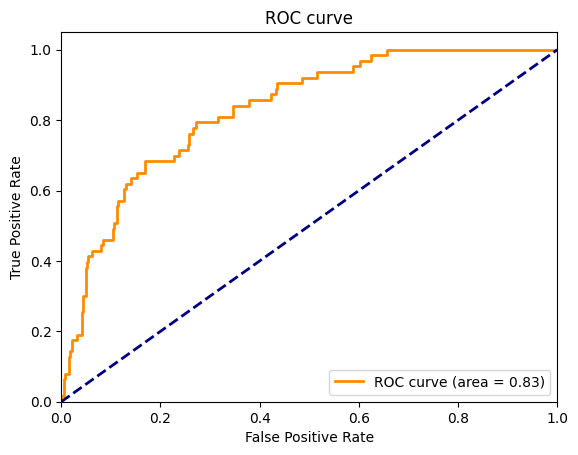

0.8294829482948294

In [73]:
# ROC curve for probit model
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model_lag_3.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [74]:
# Marginal effects from probit model
marginal_effects_lag_3 = model_lag_3.get_margeff()
marginal_effects_lag_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:        Recession_lag_3
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Employment         0.0036      0.005      0.785      0.432      -0.005       0.013
Prices             0.0091      0.004      2.238      0.025       0.001       0.017
Manufacturing      0.0057      0.004      1.262      0.207      -0.003       0.014
Construction       0.0073      0.003      2.904      0.004       0.002       0.012
Uncertainty       -0.0174      0.006     -3.143      0.002      -0.028      -0.007
Resources          0.0132      0.004      3.281      0.001       0.005       0.021
Transportation    -0.0197      0.007     -2.697      0.007      -0.034      -0.005
Outlook            0.0312      0.007      4.652      0.000       0.018       0.044
Labor              0.0013      0.004      0.357      0.721      -0.006       0.008
Capital            0.0118      0.007      1.810      0.070      -0.001       0.025
Trade              0.0104      0.004      2.501      0.012       0.002       0.019
==================================================================================
"""

# Leads to forecast recessions

In [68]:
# Create a three-period lead of the Recession dummy variable
df['Recession_lead_3'] = df['Recession'].shift(3)

# Create a six-period lead of the Recession dummy variable
df['Recession_lead_6'] = df['Recession'].shift(6)

# Create an eight-period lead of the Recession dummy variable
    # In Beige Books, this is a year ahead
df['Recession_lead_8'] = df['Recession'].shift(8)

# Create 16-period lead of the Recession dummy variable
    # In Beige Books, this is two years ahead
df['Recession_lead_16'] = df['Recession'].shift(16) 

In [105]:
# This is the same approach as Table 1, column 5 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lead_3"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_3']

# Fit the model with a logistic regression
model_lead_3 = sm.Probit(y, X).fit()

# Print the summary
model_lead_3.summary()

Optimization terminated successfully.
         Current function value: 0.208456
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_3   No. Observations:                  467
Model:                         Probit   Df Residuals:                      455
Method:                           MLE   Df Model:                           11
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.4883
Time:                        10:05:09   Log-Likelihood:                -97.349
converged:                       True   LL-Null:                       -190.24
Covariance Type:            nonrobust   LLR p-value:                 6.551e-34
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.1608      0.556     -7.486      0.000      -5.250      -3.071
Employment         0.2220      0.039      5.664      0.000       0.145       0.299
Prices             0.1084      0.033      3.288      0.001       0.044       0.173
Manufacturing      0.0215      0.031      0.689      0.491      -0.040       0.083
Construction       0.0206      0.019      1.108      0.268      -0.016       0.057
Uncertainty       -0.0267      0.039     -0.689      0.491      -0.103       0.049
Resources          0.0494      0.028      1.790      0.074      -0.005       0.103
Transportation    -0.1055      0.056     -1.886      0.059      -0.215       0.004
Outlook            0.1128      0.052      2.171      0.030       0.011       0.215
Labor             -0.0138      0.031     -0.443      0.657      -0.075       0.047
Capital            0.1188      0.045      2.632      0.008       0.030       0.207
Trade             -0.1278      0.067     -1.901      0.057      -0.260       0.004
==================================================================================
"""

In [106]:
# Predicted probabilities
predicted_probabilities = model_lead_3.predict(X)

# Actual outcomes
actual_outcomes = y

# Calculate the Brier score
brier_score = brier_score_loss(actual_outcomes, predicted_probabilities)

print(f"Brier Score Lead 3 model: {brier_score:.4f}")


Brier Score Lead 3 model: 0.0628


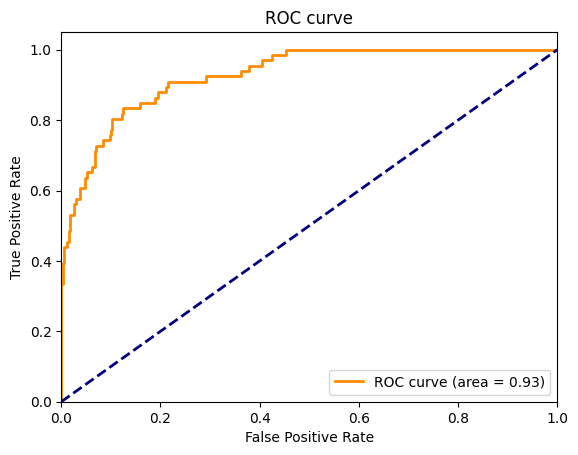

0.9276807980049876

In [77]:
# ROC curve for probit model
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model_lead_3.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [78]:
# Marginal effects from probit model
marginal_effects_lead_3 = model_lead_3.get_margeff()
marginal_effects_lead_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:       Recession_lead_3
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Employment         0.0252      0.004      6.294      0.000       0.017       0.033
Prices             0.0123      0.004      3.380      0.001       0.005       0.019
Manufacturing      0.0024      0.004      0.690      0.490      -0.004       0.009
Construction       0.0023      0.002      1.107      0.268      -0.002       0.006
Uncertainty       -0.0030      0.004     -0.689      0.491      -0.012       0.006
Resources          0.0056      0.003      1.815      0.069      -0.000       0.012
Transportation    -0.0120      0.006     -1.896      0.058      -0.024       0.000
Outlook            0.0128      0.006      2.210      0.027       0.001       0.024
Labor             -0.0016      0.004     -0.443      0.657      -0.008       0.005
Capital            0.0135      0.005      2.679      0.007       0.004       0.023
Trade             -0.0145      0.008     -1.900      0.057      -0.030       0.000
==================================================================================
"""

In [107]:
# This is the same approach as Table 1, column 6 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lead_6"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_6']

# Fit the model with a logistic regression
model_lead_6 = sm.Probit(y, X).fit()

# Print the summary
model_lead_6.summary()

Optimization terminated successfully.
         Current function value: 0.272491
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_6   No. Observations:                  464
Model:                         Probit   Df Residuals:                      452
Method:                           MLE   Df Model:                           11
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.3338
Time:                        10:05:40   Log-Likelihood:                -126.44
converged:                       True   LL-Null:                       -189.78
Covariance Type:            nonrobust   LLR p-value:                 8.122e-22
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.7965      0.410     -4.381      0.000      -2.600      -0.993
Employment         0.1059      0.030      3.505      0.000       0.047       0.165
Prices             0.0238      0.028      0.847      0.397      -0.031       0.079
Manufacturing     -0.0348      0.029     -1.189      0.234      -0.092       0.023
Construction       0.0118      0.016      0.750      0.453      -0.019       0.043
Uncertainty       -0.0217      0.030     -0.733      0.463      -0.080       0.036
Resources         -0.0382      0.030     -1.274      0.203      -0.097       0.021
Transportation    -0.0119      0.047     -0.252      0.801      -0.104       0.080
Outlook            0.0981      0.045      2.194      0.028       0.010       0.186
Labor             -0.0254      0.027     -0.956      0.339      -0.077       0.027
Capital            0.1513      0.041      3.700      0.000       0.071       0.231
Trade             -0.2777      0.078     -3.579      0.000      -0.430      -0.126
==================================================================================
"""

In [108]:
# Predicted probabilities
predicted_probabilities = model_lead_6.predict(X)

# Actual outcomes
actual_outcomes = y

# Calculate the Brier score
brier_score = brier_score_loss(actual_outcomes, predicted_probabilities)

print(f"Brier Score Lead 6 model: {brier_score:.4f}")


Brier Score Lead 6 model: 0.0811


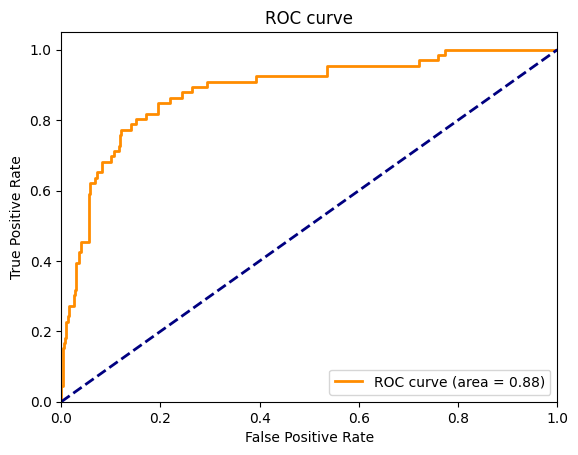

0.8837749352824729

In [82]:
# ROC curve for probit model
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model_lead_6.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [83]:
# Marginal effects from probit model
marginal_effects_lead_6 = model_lead_6.get_margeff()
marginal_effects_lead_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:       Recession_lead_6
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Employment         0.0160      0.004      3.635      0.000       0.007       0.025
Prices             0.0036      0.004      0.848      0.397      -0.005       0.012
Manufacturing     -0.0053      0.004     -1.194      0.232      -0.014       0.003
Construction       0.0018      0.002      0.750      0.454      -0.003       0.006
Uncertainty       -0.0033      0.004     -0.734      0.463      -0.012       0.005
Resources         -0.0058      0.005     -1.278      0.201      -0.015       0.003
Transportation    -0.0018      0.007     -0.252      0.801      -0.016       0.012
Outlook            0.0149      0.007      2.222      0.026       0.002       0.028
Labor             -0.0038      0.004     -0.956      0.339      -0.012       0.004
Capital            0.0229      0.006      3.878      0.000       0.011       0.035
Trade             -0.0421      0.012     -3.646      0.000      -0.065      -0.019
==================================================================================
"""

In [109]:
# This uses an 8-period (one-year) lead
# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lead_8"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_8']

# Fit the model with a logistic regression
model_lead_8 = sm.Probit(y, X).fit()

# Print the summary
model_lead_8.summary()

Optimization terminated successfully.
         Current function value: 0.280855
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_8   No. Observations:                  462
Model:                         Probit   Df Residuals:                      450
Method:                           MLE   Df Model:                           11
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.3152
Time:                        10:05:58   Log-Likelihood:                -129.75
converged:                       True   LL-Null:                       -189.47
Covariance Type:            nonrobust   LLR p-value:                 2.352e-20
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8154      0.423     -1.927      0.054      -1.645       0.014
Employment         0.0889      0.030      2.967      0.003       0.030       0.148
Prices            -0.0087      0.028     -0.310      0.757      -0.064       0.047
Manufacturing     -0.0715      0.030     -2.419      0.016      -0.129      -0.014
Construction       0.0157      0.016      0.989      0.323      -0.015       0.047
Uncertainty       -0.0719      0.033     -2.157      0.031      -0.137      -0.007
Resources         -0.1039      0.034     -3.044      0.002      -0.171      -0.037
Transportation     0.1353      0.036      3.774      0.000       0.065       0.206
Outlook            0.0317      0.047      0.671      0.502      -0.061       0.124
Labor             -0.1019      0.032     -3.172      0.002      -0.165      -0.039
Capital            0.1822      0.042      4.328      0.000       0.100       0.265
Trade             -0.1805      0.067     -2.687      0.007      -0.312      -0.049
==================================================================================
"""

In [110]:
# Predicted probabilities
predicted_probabilities = model_lead_8.predict(X)

# Actual outcomes
actual_outcomes = y

# Calculate the Brier score
brier_score = brier_score_loss(actual_outcomes, predicted_probabilities)

print(f"Brier Score Lead 8 model: {brier_score:.4f}")


Brier Score Lead 8 model: 0.0893


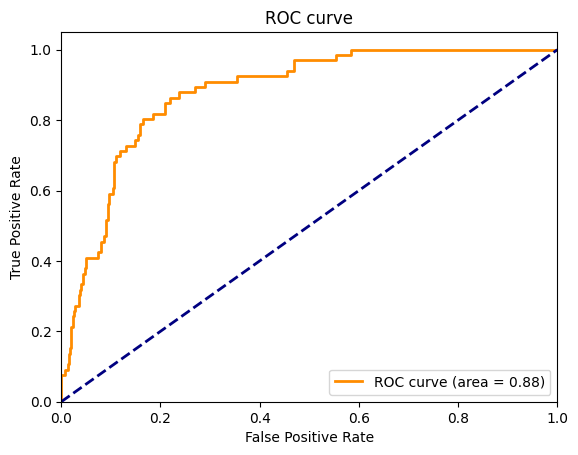

0.8790557086011631

In [85]:
# ROC curve for probit model
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model_lead_8.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [86]:
# Marginal effects from probit model
marginal_effects_lead_8 = model_lead_8.get_margeff()
marginal_effects_lead_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:       Recession_lead_8
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Employment         0.0137      0.004      3.050      0.002       0.005       0.023
Prices            -0.0013      0.004     -0.309      0.757      -0.010       0.007
Manufacturing     -0.0110      0.004     -2.465      0.014      -0.020      -0.002
Construction       0.0024      0.002      0.993      0.321      -0.002       0.007
Uncertainty       -0.0111      0.005     -2.185      0.029      -0.021      -0.001
Resources         -0.0160      0.005     -3.117      0.002      -0.026      -0.006
Transportation     0.0209      0.005      3.904      0.000       0.010       0.031
Outlook            0.0049      0.007      0.672      0.502      -0.009       0.019
Labor             -0.0157      0.005     -3.240      0.001      -0.025      -0.006
Capital            0.0281      0.006      4.703      0.000       0.016       0.040
Trade             -0.0279      0.010     -2.714      0.007      -0.048      -0.008
==================================================================================
"""

In [112]:
# This uses an 16-period (one-year) lead
# Drop rows with missing values
dfBinary = df.dropna(subset=["Recession_lead_16"])

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_16']

# Fit the model with a logistic regression
model_lead_16 = sm.Probit(y, X).fit()

# Print the summary
model_lead_16.summary()

Optimization terminated successfully.
         Current function value: 0.323607
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:      Recession_lead_16   No. Observations:                  454
Model:                         Probit   Df Residuals:                      442
Method:                           MLE   Df Model:                           11
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.2195
Time:                        10:09:10   Log-Likelihood:                -146.92
converged:                       True   LL-Null:                       -188.23
Covariance Type:            nonrobust   LLR p-value:                 4.581e-13
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.9069      0.384     -2.360      0.018      -1.660      -0.154
Employment         0.0761      0.030      2.502      0.012       0.016       0.136
Prices             0.0241      0.025      0.967      0.334      -0.025       0.073
Manufacturing     -0.0884      0.030     -2.930      0.003      -0.148      -0.029
Construction       0.0238      0.015      1.623      0.105      -0.005       0.053
Uncertainty        0.0167      0.021      0.779      0.436      -0.025       0.059
Resources         -0.1161      0.033     -3.559      0.000      -0.180      -0.052
Transportation     0.0536      0.035      1.512      0.131      -0.016       0.123
Outlook           -0.1657      0.055     -3.019      0.003      -0.273      -0.058
Labor             -0.0847      0.025     -3.408      0.001      -0.133      -0.036
Capital            0.1569      0.040      3.925      0.000       0.079       0.235
Trade              0.0358      0.022      1.592      0.111      -0.008       0.080
==================================================================================
"""

In [113]:
# Predicted probabilities
predicted_probabilities = model_lead_16.predict(X)

# Actual outcomes
actual_outcomes = y

# Calculate the Brier score
brier_score = brier_score_loss(actual_outcomes, predicted_probabilities)

print(f"Brier Score Lead 16 model: {brier_score:.4f}")


Brier Score Lead 16 model: 0.0960


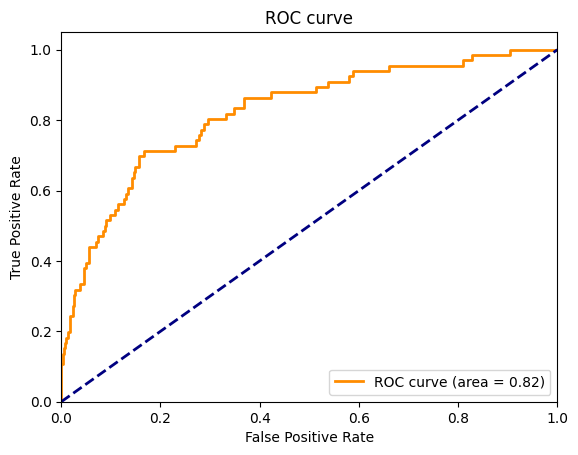

0.8226726023117776

In [88]:
# ROC curve for probit model
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model_lead_16.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [89]:
# Marginal effects from probit model
marginal_effects_lead_16 = model_lead_16.get_margeff()
marginal_effects_lead_16.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:      Recession_lead_16
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Employment         0.0138      0.005      2.539      0.011       0.003       0.025
Prices             0.0044      0.005      0.971      0.331      -0.004       0.013
Manufacturing     -0.0161      0.005     -2.971      0.003      -0.027      -0.005
Construction       0.0043      0.003      1.629      0.103      -0.001       0.010
Uncertainty        0.0030      0.004      0.781      0.435      -0.005       0.011
Resources         -0.0211      0.006     -3.634      0.000      -0.032      -0.010
Transportation     0.0097      0.006      1.522      0.128      -0.003       0.022
Outlook           -0.0301      0.010     -3.097      0.002      -0.049      -0.011
Labor             -0.0154      0.004     -3.466      0.001      -0.024      -0.007
Capital            0.0285      0.007      4.090      0.000       0.015       0.042
Trade              0.0065      0.004      1.595      0.111      -0.001       0.014
==================================================================================
"""

# Results

In [93]:
# List of models
models = {
    "Now": model_now,
    "3-month Lag": model_lag_3,
    "6-month Lag": model_lag_6,
    "3-month Lead": model_lead_3,
    "6-month Lead": model_lead_6,
    "8-month Lead": model_lead_8,
    "16-month Lead": model_lead_16
}


# Create an empty DataFrame for the formatted results
formatted_results = pd.DataFrame()

# Define significance stars based on p-value thresholds
def significance_stars(pval):
    if pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    else:
        return ''

# Populate the DataFrame
for model_name, model in models.items():
    # Extract coefficients and p-values
    coeffs = model.params.round(2)
    pvals = model.pvalues.round(2)
    
    # Combine coefficients, significance stars, and p-values
    formatted = coeffs.map(str) + coeffs.index.map(
        lambda var: significance_stars(pvals[var])
    ) + "\n(" + pvals.map(str) + ")"
    
    # Add the formatted results as a column
    formatted_results[model_name] = formatted

# Set index to topic names (variables)
formatted_results.index = model.params.index

# Display the DataFrame
from IPython.display import display
formatted_results

# Save to Excel or CSV (optional)
#formatted_results.to_excel('formatted_probit_results.xlsx')
#formatted_results.to_csv('formatted_probit_results.csv')

,Now,3-month Lag,6-month Lag,3-month Lead,6-month Lead,8-month Lead,16-month Lead
const,-5.08**\n(0.0),-2.95**\n(0.0),-2.0**\n(0.0),-4.16**\n(0.0),-1.8**\n(0.0),-0.82*\n(0.05),-0.91*\n(0.02)
Employment,0.2**\n(0.0),0.02\n(0.43),-0.1**\n(0.0),0.22**\n(0.0),0.11**\n(0.0),0.09**\n(0.0),0.08**\n(0.01)
Prices,0.13**\n(0.0),0.05*\n(0.03),0.04\n(0.06),0.11**\n(0.0),0.02\n(0.4),-0.01\n(0.76),0.02\n(0.33)
Manufacturing,0.05\n(0.13),0.03\n(0.21),0.05\n(0.07),0.02\n(0.49),-0.03\n(0.23),-0.07*\n(0.02),-0.09**\n(0.0)
Construction,0.05**\n(0.01),0.04**\n(0.0),0.05**\n(0.0),0.02\n(0.27),0.01\n(0.45),0.02\n(0.32),0.02\n(0.1)
Uncertainty,-0.17**\n(0.0),-0.1**\n(0.0),-0.14**\n(0.0),-0.03\n(0.49),-0.02\n(0.46),-0.07*\n(0.03),0.02\n(0.44)
Resources,0.1**\n(0.0),0.08**\n(0.0),0.1**\n(0.0),0.05\n(0.07),-0.04\n(0.2),-0.1**\n(0.0),-0.12**\n(0.0)
Transportation,-0.11*\n(0.03),-0.12**\n(0.01),-0.06\n(0.09),-0.11\n(0.06),-0.01\n(0.8),0.14**\n(0.0),0.05\n(0.13)
Outlook,0.18**\n(0.0),0.19**\n(0.0),0.12**\n(0.01),0.11*\n(0.03),0.1*\n(0.03),0.03\n(0.5),-0.17**\n(0.0)
Labor,0.01\n(0.79),0.01\n(0.72),-0.01\n(0.48),-0.01\n(0.66),-0.03\n(0.34),-0.1**\n(0.0),-0.08**\n(0.0)


In [94]:
models = {'Lag 6': model_lag_6, 'Lag 3': model_lag_3, 'Now': model_now, 'Lead 3': model_lead_3, 'Lead 6': model_lead_6, 'Lead 8': model_lead_8, 'Lead 16': model_lead_16}

# Create an empty dictionary to store pseudo R-squared values
pseudo_r_squared = {}

# Populate the dictionary with pseudo R-squared values for each model
for model_name, model in models.items():
    pseudo_r_squared[model_name] = model.prsquared  # Extract pseudo R-squared

# Convert the dictionary into a DataFrame
pseudo_r_squared_df = pd.DataFrame.from_dict(pseudo_r_squared, orient='index', columns=['Pseudo R-Squared'])

# Format the values (rounded to 3 decimals)
pseudo_r_squared_df = pseudo_r_squared_df.round(3)

# Display the DataFrame
from IPython.display import display
display(pseudo_r_squared_df)


,Pseudo R-Squared
Lag 6,0.159
Lag 3,0.221
Now,0.489
Lead 3,0.488
Lead 6,0.334
Lead 8,0.315
Lead 16,0.219


In [96]:
# Extract variable names (topics) from one of the models
variable_names = [name for name in model_lag_6.model.exog_names if name.lower() != 'const']

# Create a DataFrame to store the marginal effects
marginal_effects_df = pd.DataFrame({
    'Lag 6': marginal_effects_lag_6.margeff.round(3),
    'Lag 3': marginal_effects_lag_3.margeff.round(3),
    'Now': marginal_effects_now.margeff.round(3),
    'Lead 3': marginal_effects_lead_3.margeff.round(3),
    'Lead 6': marginal_effects_lead_6.margeff.round(3),
    'Lead 8': marginal_effects_lead_8.margeff.round(3),
    'Lead 16': marginal_effects_lead_16.margeff.round(3)
}, index=variable_names)

# Display the DataFrame
from IPython.display import display
display(marginal_effects_df)


,Lag 6,Lag 3,Now,Lead 3,Lead 6,Lead 8,Lead 16
Employment,-0.018,0.004,0.023,0.025,0.016,0.014,0.014
Prices,0.008,0.009,0.014,0.012,0.004,-0.001,0.004
Manufacturing,0.009,0.006,0.005,0.002,-0.005,-0.011,-0.016
Construction,0.010,0.007,0.006,0.002,0.002,0.002,0.004
Uncertainty,-0.024,-0.017,-0.019,-0.003,-0.003,-0.011,0.003
Resources,0.017,0.013,0.011,0.006,-0.006,-0.016,-0.021
Transportation,-0.011,-0.020,-0.013,-0.012,-0.002,0.021,0.010
Outlook,0.021,0.031,0.021,0.013,0.015,0.005,-0.030
Labor,-0.003,0.001,0.001,-0.002,-0.004,-0.016,-0.015
Capital,0.008,0.012,0.014,0.014,0.023,0.028,0.029


In [114]:
# Calculate AIC and BIC for all the models
aic_bic = {}

for model_name, model in models.items():
    aic_bic[model_name] = {
        'AIC': model.aic,
        'BIC': model.bic
    }

# Convert the dictionary into a DataFrame
aic_bic_df = pd.DataFrame.from_dict(aic_bic, orient='index')

# Display the DataFrame
from IPython.display import display
display(aic_bic_df)

,AIC,BIC
Lag 6,324.422191,374.100805
Lag 3,311.897898,361.653849
Now,218.814300,268.647093
Lead 3,218.697961,268.453912
Lead 6,276.871331,326.549945
Lead 8,283.509720,333.136499
Lead 16,317.835476,367.252643


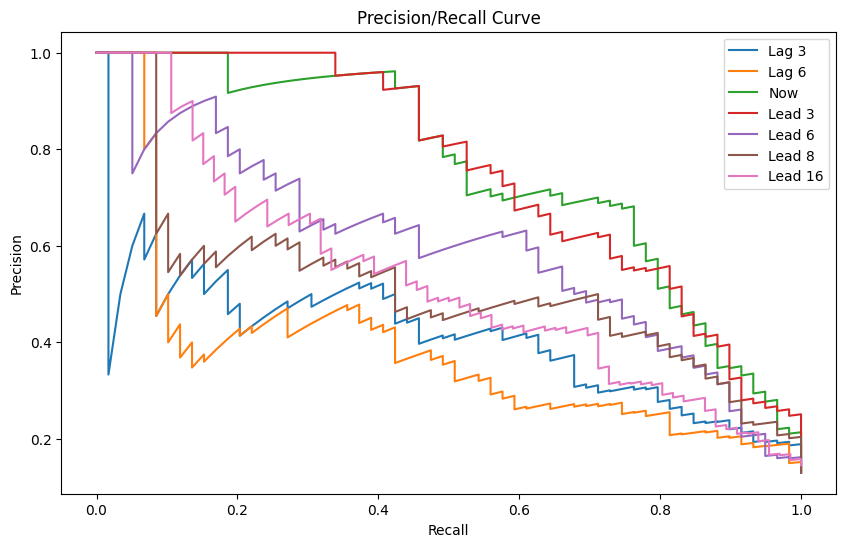

In [124]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import pandas as pd

# Define a helper function to drop NaN values consistently between y_true and y_pred
def drop_na(y_true, y_pred):
    mask = ~y_true.isna() & ~y_pred.isna()
    return y_true[mask], y_pred[mask]

# Ensure 'df' and models are loaded with all required predictions and data
# Define the actual outcomes
y_true_lag_3 = df['Recession_lag_3']
y_true_lag_6 = df['Recession_lag_6']
y_true_now = df['Recession']
y_true_lead_3 = df['Recession_lead_3']
y_true_lead_6 = df['Recession_lead_6']
y_true_lead_8 = df['Recession_lead_8']
y_true_lead_16 = df['Recession_lead_16']

# Define the predicted probabilities for each model
y_pred_lag_3 = model_lag_3.predict(X)
y_pred_lag_6 = model_lag_6.predict(X)
y_pred_now = model_now.predict(X)
y_pred_lead_3 = model_lead_3.predict(X)
y_pred_lead_6 = model_lead_6.predict(X)
y_pred_lead_8 = model_lead_8.predict(X)
y_pred_lead_16 = model_lead_16.predict(X)

# Drop NaN values for each pair of true and predicted values
y_true_lag_3, y_pred_lag_3 = drop_na(y_true_lag_3, y_pred_lag_3)
y_true_lag_6, y_pred_lag_6 = drop_na(y_true_lag_6, y_pred_lag_6)
y_true_now, y_pred_now = drop_na(y_true_now, y_pred_now)
y_true_lead_3, y_pred_lead_3 = drop_na(y_true_lead_3, y_pred_lead_3)
y_true_lead_6, y_pred_lead_6 = drop_na(y_true_lead_6, y_pred_lead_6)
y_true_lead_8, y_pred_lead_8 = drop_na(y_true_lead_8, y_pred_lead_8)
y_true_lead_16, y_pred_lead_16 = drop_na(y_true_lead_16, y_pred_lead_16)

# Calculate precision and recall for each model
precision_lag_3, recall_lag_3, _ = precision_recall_curve(y_true_lag_3, y_pred_lag_3)
precision_lag_6, recall_lag_6, _ = precision_recall_curve(y_true_lag_6, y_pred_lag_6)
precision_now, recall_now, _ = precision_recall_curve(y_true_now, y_pred_now)
precision_lead_3, recall_lead_3, _ = precision_recall_curve(y_true_lead_3, y_pred_lead_3)
precision_lead_6, recall_lead_6, _ = precision_recall_curve(y_true_lead_6, y_pred_lead_6)
precision_lead_8, recall_lead_8, _ = precision_recall_curve(y_true_lead_8, y_pred_lead_8)
precision_lead_16, recall_lead_16, _ = precision_recall_curve(y_true_lead_16, y_pred_lead_16)

# Plot the precision/recall curves
plt.figure(figsize=(10, 6))
plt.plot(recall_lag_3, precision_lag_3, label='Lag 3')
plt.plot(recall_lag_6, precision_lag_6, label='Lag 6')
plt.plot(recall_now, precision_now, label='Now')
plt.plot(recall_lead_3, precision_lead_3, label='Lead 3')
plt.plot(recall_lead_6, precision_lead_6, label='Lead 6')
plt.plot(recall_lead_8, precision_lead_8, label='Lead 8')
plt.plot(recall_lead_16, precision_lead_16, label='Lead 16')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend()
plt.show()


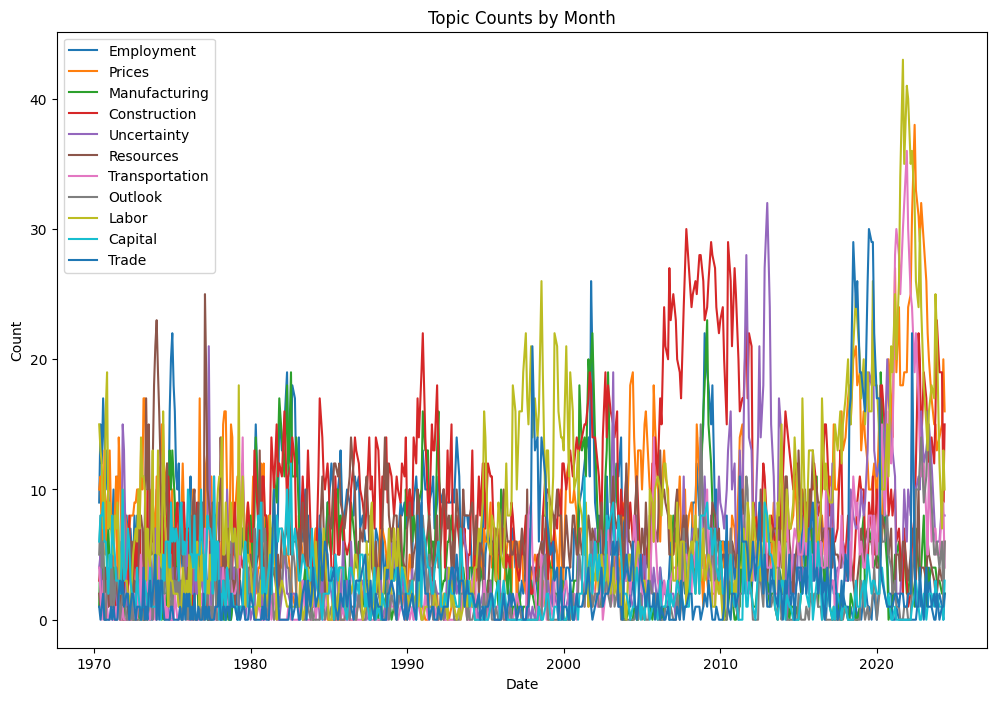

In [126]:
# Table with counts of topics by month
topic_counts = results_df.groupby("DATE")[topic_columns].sum()

# Plot the topic counts
plt.figure(figsize=(12, 8))
for column in topic_counts.columns:
    plt.plot(topic_counts.index, topic_counts[column], label=column)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Topic Counts by Month')
plt.legend()
plt.show()

In [129]:
# export to csv
topic_counts.to_csv("topic_counts.csv")